# Auxiliary-field Quantum Monte Carlo: ground state energy of H$_2$

In this notebook, we demonstrate how to augment classical QMC calculations using quantum computers (QC) using auxiliary-field QMC (AFQMC) [1]. Compared to the variational quantum eigensolver (VQE) [2], a popular quantum algorithm for solving the electronic structure problem, QC‑AFQMC does not require an expensive optimization loop. The circuit depth of both methods is similar. This notebook presents an example AFQMC calculation to find the ground state of H$_2$ molecule. The code can be run on both classical simulators and quantum computers. For more details about the algorithm, see this [example notebook](https://github.com/aws/amazon-braket-examples/blob/feature/quantum-monte-carlo/examples/hybrid_quantum_algorithms/Quantum_Monte_Carlo_Chemistry/Quantum_Monte_Carlo_Chemistry.ipynb) in Amazon Braket Examples.


[1] Motta, Mario, and Shiwei Zhang. "Ab initio computations of molecular systems by the auxiliary‐field quantum Monte Carlo method." [Wiley Interdisciplinary Reviews: Computational Molecular Science 8.5 (2018): e1364](https://doi.org/10.1002/wcms.1364).

[2] Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." [Nature Communications 5.1 (2014): 1-7](https://www.nature.com/articles/ncomms5213?ref=https://githubhelp.com).

<div class="alert alert-block alert-info">
<b>Note:</b> The code in this notebook has option to use multiprocessing for computations. A notebook instance with multiple CPU cores is required to use multiprocessing. With a ml.m5.24xlarge notebook instance, the code takes about 6 minutes in total to run in this notebook, which will incur charge for about \$0.6 USD. The notebook also creates a Braket job to compute a scaled-up QMC workload that takes about 30 minutes with a ml.m5.24xlarge job instance, which will incur charge for about \$2.8 USD.
</div>

In [1]:
import os
import time

import numpy as np
import pennylane as qml
from braket.experimental.algorithms.afqmc.classical_afqmc import chemistry_preparation, greens_pq, local_energy
from braket.experimental.algorithms.afqmc.quantum_afqmc import quantum_afqmc
from pyscf import fci, gto

np.set_printoptions(precision=4, edgeitems=10, linewidth=150, suppress=True)

## Prepare the operators for AFQMC calculations of the ground state of H$_2$

Here we demonstrate the performance of the quantum assisted AFQMC algorithm on the example of H$_2$ molecule. We begin by preparing the Hamiltonian of the H$_2$ molecule, and determining the energy of a classical trial state corresponding to the Hartree-Fock state.

In [2]:
from braket.experimental.algorithms.afqmc.classical_afqmc import chemistry_preparation, greens_pq, local_energy
from pyscf import fci, gto, scf

# perform HF calculations
mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 0.75", basis="sto-3g")
hf = mol.RHF()
hf.kernel()

# perform full configuration interaction (FCI) calculations
myci = fci.FCI(hf)
myci.kernel()

trial = np.array([[1, 0], [0, 1], [0, 0], [0, 0]])
prop = chemistry_preparation(mol, hf, trial)


# Separate the spin up and spin down channel of the trial state
trial_up = trial[::2, ::2]
trial_down = trial[1::2, 1::2]

# compute its one particle Green's function
G = [greens_pq(trial_up, trial_up), greens_pq(trial_down, trial_down)]
Ehf = local_energy(prop.h1e, prop.eri, G, prop.nuclear_repulsion)
print(f"The Hartree-Fock energy computed from local_energy is {np.round(Ehf, 10)}.")

converged SCF energy = -1.1161514489386
The Hartree-Fock energy computed from local_energy is -1.1161514489.


### Run Quantum AFQMC on local simulator

Now, We are ready to carry out the QAEE calculation in the next two cells and find the ground state of H$_2$.

<div class="alert alert-block alert-info">
<b>Note:</b> The following cell of quantum AFQMC calculation will take  about 5 mins with 48 core parallelization. You may need to execute the notebook on a notebook instance with 48 or more CPU cores to utilize 48 core parallelization. We executed this notebook on a m5.24xlarge instance.
</div>

In [3]:
from braket.experimental.algorithms.afqmc.quantum_afqmc import quantum_afqmc

dtau = 0.005
num_steps = 600
num_walkers = 2000
quantum_evaluations_every_n_steps = 50

dev = qml.device("lightning.qubit", wires=4)

In [4]:
%%time

quantum_energies, energies = quantum_afqmc(
    num_walkers,
    num_steps,
    dtau,
    quantum_evaluations_every_n_steps,
    trial,
    prop,
    max_pool=48,
    dev=dev,
)

CPU times: user 2.79 s, sys: 1.4 s, total: 4.19 s
Wall time: 6min 6s


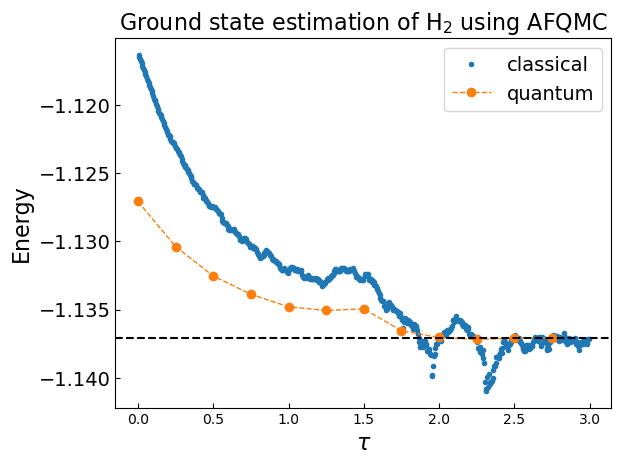

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(
    dtau * np.arange(num_steps),
    energies,
    linestyle="dashed",
    marker=".",
    color="tab:blue",
    linewidth=0,
    label="classical",
)
plt.plot(
    dtau * np.arange(0, num_steps, quantum_evaluations_every_n_steps),
    quantum_energies,
    linestyle="dashed",
    marker="o",
    color="tab:orange",
    linewidth=1,
    label="quantum",
)
plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
plt.title(r"Ground state estimation of H$_2$ using AFQMC", fontsize=16)
plt.legend(fontsize=14, loc="upper right")
plt.xlabel(r"$\tau$", fontsize=16)
plt.ylabel("Energy", fontsize=16)
plt.yticks(fontsize=14)
plt.tick_params(direction="in")
plt.show()

In the plot, the computed ground-state energy of the H$_2$ molecule against imaginary time $\tau$ above, the blue curve labeled "classical" denotes the ground-state energy computed by using the classical trial state, i.e., the Hartree-Fock state. The orange curve labeled "quantum" denotes the ground-state energy computed using the QAEE-AFQMC algorithm on the PennyLane Simulator. The black dashed line represents the true ground state energy. We see that both classical and quantum methods converge to the correct value. However, the energies computed using QAEE-AFQMC have a smaller variance, demonstrating one of the main benefits of this approach.